In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import os
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

In [3]:
# parallel processing
from multiprocessing import Pool

In [4]:
# samwich routines
from samwich.dataloaders import XarrayData
from samwich.waketrackers import track

In [5]:
# case definition
from study import V27, neutral
from trajectory import Trajectory

# Meandering-Frame-of-Reference Analysis

In [6]:
case = neutral(casedir='WAKEBENCH-NREL_DEBNATH_LES/neutral',
               prefix='NREL_DEBNATH_LES_20190325',
               turbine=V27)

In [78]:
trackers = {
    '2D Gaussian': 'Gaussian2D',
    '1D Gaussian (Bastankhah)': 'Gaussian',
    'Const area': 'ConstantArea',
    'Const momentum deficit': 'ConstantFlux',
}
wakedata = {
    '2D Gaussian': '2D_Gaussian',
    '1D Gaussian (Bastankhah)': '1D_Gaussian_Bastankhah',
    'Const area': 'Constant-Area_Contours',
    'Const momentum deficit': 'Constant-Xmom_Contours',
}
suffix = '--filtered'

In [8]:
sample_times = np.arange(16150,17812+1) # from Mithu's original data

In [9]:
ds = 0.25
D = case.turbine.D
ymin,ymax = -1.5*D, 1.5*D
zmin,zmax = -1.5*D, 1.5*D # relative to hub height

## set up MFoR grid

In [10]:
# points for pcolormesh
y0 = np.arange(ymin,ymax+ds,ds)
z0 = np.arange(zmin,zmax+ds,ds)
yy,zz = np.meshgrid(y0,z0,indexing='ij')

In [11]:
# points to pass to `wake.to_MFoR()`
y1 = (y0[1:] + y0[:-1]) / 2
z1 = (z0[1:] + z0[:-1]) / 2

## read all planes

In [12]:
%%time
dataplanes = {
    downD: XarrayData(case.get_wake_datafile(downD),
                      uvar='U',vvar='V',wvar='W',
                      trim_time=case.trim_time(downD))
    for downD in case.downstreamD
}

Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_2D.nc
Calculated offset: 13
Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_3D.nc
Calculated offset: 17
Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_4D.nc
Calculated offset: 20
Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_5D.nc
Calculated offset: 23
Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_6D.nc
Calculated offset: 26
Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_7D.nc
Calculated offset: 29
Selected datafile: WAKEBENCH-NREL_DEBNATH_LES/neutral/NREL_DEBNATH_LES_20190325_uvw_8D.nc
Calculated offset: 32
CPU times: user 10 s, sys: 10.4 s, total: 20.4 s
Wall time: 20.9 s


In [13]:
maxlen = len(case.get_inflow(case.downstreamD[-1]))
maxlen

1572

In [14]:
times = sample_times[-maxlen:]

## load trackers 
for MFoR transformation

In [15]:
def get_plane_mfor(name,downD):
    data = dataplanes[downD]
    wo = track(data.sliceI(), method=trackers[name])
    wo.remove_shear(wind_profile=case.get_inflow(downD))
    outfiles = case.get_outputs(wakedata[name],downD,suffix=suffix)
    wo._read_trajectory(outfiles['trajectory_file'])
    #wo._read_outlines(outfiles['outlines_file'])
    wo.to_MFoR(y1,z1)
    return wo.u_mfor[-maxlen:,:,:]

### mean wake

In [76]:
def get_mean_wake_mfor(name,output=None):
    planes = []
    for downD in case.downstreamD:
        planes.append(get_plane_mfor(name,downD).mean(axis=0))
    fullwake = np.stack(planes,axis=0) # dims==(x,y,z)
        
    wake_mfor = xr.Dataset(
        data_vars={
            'u': (('x_D','y_D','z_D'), fullwake),
        },
        coords={
            'x_D': case.downstreamD,
            'y_D': y1/D,
            'z_D': z1/D
        }
    )
    
    if output is not None:
        outfile = os.path.join(case.casedir, wakedata[name]+suffix, output)
        print('Writing',outfile)
        wake_mfor.to_netcdf(outfile)
    
    return wake_mfor

In [41]:
%%time
for name in wakedata.keys():
    get_mean_wake_mfor(name, output='mean_wake_mfor.nc')
# 3 datasets:
# CPU times: user 1min 55s, sys: 21.9 s, total: 2min 17s
# Wall time: 2min 23s

Slicing data at i=0 x=54.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 54.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1591

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_2D.csv
Interpolating with RectBivariateSpline


Transform: frame 1590


Slicing data at i=0 x=81.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 81.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1587

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_3D.csv
Interpolating with RectBivariateSpline


Transform: frame 1586


Slicing data at i=0 x=108.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 108.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1584

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_4D.csv
Interpolating with RectBivariateSpline


Transform: frame 1583


Slicing data at i=0 x=135.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 135.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1581

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_5D.csv
Interpolating with RectBivariateSpline


Transform: frame 1580


Slicing data at i=0 x=162.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 162.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1578

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_6D.csv
Interpolating with RectBivariateSpline


Transform: frame 1577


Slicing data at i=0 x=189.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 189.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1575

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_7D.csv
Interpolating with RectBivariateSpline


Transform: frame 1574


Slicing data at i=0 x=216.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 216.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1572

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_8D.csv
Interpolating with RectBivariateSpline


Transform: frame 1571


Writing WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/mean_wake_mfor.nc
Slicing data at i=0 x=54.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 54.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1591

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_2D.csv
Interpolating with RectBivariateSpline


Transform: frame 1590


Slicing data at i=0 x=81.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 81.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1587

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_3D.csv
Interpolating with RectBivariateSpline


Transform: frame 1586


Slicing data at i=0 x=108.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 108.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1584

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_4D.csv
Interpolating with RectBivariateSpline


Transform: frame 1583


Slicing data at i=0 x=135.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 135.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1581

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_5D.csv
Interpolating with RectBivariateSpline


Transform: frame 1580


Slicing data at i=0 x=162.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 162.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1578

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_6D.csv
Interpolating with RectBivariateSpline


Transform: frame 1577


Slicing data at i=0 x=189.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 189.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1575

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_7D.csv
Interpolating with RectBivariateSpline


Transform: frame 1574


Slicing data at i=0 x=216.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 216.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1572

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_8D.csv
Interpolating with RectBivariateSpline


Transform: frame 1571


Writing WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/mean_wake_mfor.nc
Slicing data at i=0 x=54.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 54.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1591

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_2D.csv
Interpolating with RectBivariateSpline


Transform: frame 1590


Slicing data at i=0 x=81.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 81.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1587

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_3D.csv
Interpolating with RectBivariateSpline


Transform: frame 1586


Slicing data at i=0 x=108.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 108.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1584

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_4D.csv
Interpolating with RectBivariateSpline


Transform: frame 1583


Slicing data at i=0 x=135.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 135.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1581

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_5D.csv
Interpolating with RectBivariateSpline


Transform: frame 1580


Slicing data at i=0 x=162.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 162.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1578

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_6D.csv
Interpolating with RectBivariateSpline


Transform: frame 1577


Slicing data at i=0 x=189.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 189.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1575

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_7D.csv
Interpolating with RectBivariateSpline


Transform: frame 1574


Slicing data at i=0 x=216.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 216.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1572

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_8D.csv
Interpolating with RectBivariateSpline


Transform: frame 1571


Writing WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/mean_wake_mfor.nc
CPU times: user 1min 55s, sys: 21.9 s, total: 2min 17s
Wall time: 2min 23s


## variance in wake edge

In [66]:
da = xr.DataArray(u_mfor,dims=['simtime','y_D','z_D'])

In [70]:
%time da.rolling(dim={'simtime':600}).std()

CPU times: user 4.27 s, sys: 543 ms, total: 4.81 s
Wall time: 4.83 s


<xarray.DataArray (simtime: 1572, y_D: 324, z_D: 324)>
array([[[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       [[     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan],
        ...,
        [     nan,      nan, ...,      nan,      nan],
        [     nan,      nan, ...,      nan,      nan]],

       ...,

       [[0.699818, 0.699999, ..., 0.711029, 0.710913],
        [0.698261, 0.698365, ..., 0.70955 , 0.709526],
        ...,
        [0.685164, 0.68494 , ..., 0.572053, 0.570652],
        [0.681642, 0.681428, ..., 0.572061, 0.57058 ]],

       [[0.699274, 0.699456, ..., 0.710138, 0.70999 ],
        [0.697566, 0.69767 , ..., 0.70868 , 0.70862 ],
        ...,
        [0.685445, 0.68522 , ..., 0.570298, 0.56889 ],
        [0.681959, 0.681744, ..., 0.570303, 0.568

In [81]:
def get_wake_stdev_mfor(name,output=None):
    planes = []
    for downD in case.downstreamD:
        da = xr.DataArray(get_plane_mfor(name,downD),
                          dims=['simtime','y_D','z_D'])
        da_stdev = da.rolling(dim={'simtime':600}).std()
        planes.append(da_stdev.mean(dim='simtime'))
    fullwake = xr.concat(planes,dim='x_D') # dims==(x,y,z)
        
    wake_mfor = xr.Dataset(
        data_vars={
            'stdev_u': fullwake,
        },
        coords={
            'x_D': case.downstreamD,
            'y_D': y1/D,
            'z_D': z1/D
        }
    )
    
    if output is not None:
        outfile = os.path.join(case.casedir, wakedata[name]+suffix, output)
        print('Writing',outfile)
        wake_mfor.to_netcdf(outfile)
    
    return wake_mfor

In [73]:
%%time
for name in wakedata.keys():
    get_wake_stdev_mfor(name, output='wake_stdev_mfor.nc')
# 3 datasets:
# CPU times: user 3min 41s, sys: 53 s, total: 4min 34s
# Wall time: 4min 47s

Slicing data at i=0 x=54.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 54.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1591

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_2D.csv
Interpolating with RectBivariateSpline


Transform: frame 1590


Slicing data at i=0 x=81.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 81.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1587

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_3D.csv
Interpolating with RectBivariateSpline


Transform: frame 1586


Slicing data at i=0 x=108.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 108.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1584

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_4D.csv
Interpolating with RectBivariateSpline


Transform: frame 1583


Slicing data at i=0 x=135.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 135.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1581

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_5D.csv
Interpolating with RectBivariateSpline


Transform: frame 1580


Slicing data at i=0 x=162.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 162.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1578

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_6D.csv
Interpolating with RectBivariateSpline


Transform: frame 1577


Slicing data at i=0 x=189.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 189.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1575

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_7D.csv
Interpolating with RectBivariateSpline


Transform: frame 1574


Slicing data at i=0 x=216.0
Selected Tracker: Gaussian2D

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 216.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1572

...finished initializing WakeTracker

...finished initializing Gaussian2D 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/trajectory_8D.csv
Interpolating with RectBivariateSpline


Transform: frame 1571


Writing WAKEBENCH-NREL_DEBNATH_LES/neutral/2D_Gaussian--filtered/wake_stdev_mfor.nc
Slicing data at i=0 x=54.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 54.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1591

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_2D.csv
Interpolating with RectBivariateSpline


Transform: frame 1590


Slicing data at i=0 x=81.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 81.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1587

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_3D.csv
Interpolating with RectBivariateSpline


Transform: frame 1586


Slicing data at i=0 x=108.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 108.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1584

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_4D.csv
Interpolating with RectBivariateSpline


Transform: frame 1583


Slicing data at i=0 x=135.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 135.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1581

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_5D.csv
Interpolating with RectBivariateSpline


Transform: frame 1580


Slicing data at i=0 x=162.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 162.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1578

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_6D.csv
Interpolating with RectBivariateSpline


Transform: frame 1577


Slicing data at i=0 x=189.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 189.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1575

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_7D.csv
Interpolating with RectBivariateSpline


Transform: frame 1574


Slicing data at i=0 x=216.0
Selected Tracker: Gaussian

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 216.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1572

...finished initializing WakeTracker

...finished initializing Gaussian 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/trajectory_8D.csv
Interpolating with RectBivariateSpline


Transform: frame 1571


Writing WAKEBENCH-NREL_DEBNATH_LES/neutral/1D_Gaussian_Bastankhah--filtered/wake_stdev_mfor.nc
Slicing data at i=0 x=54.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 54.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1591

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_2D.csv
Interpolating with RectBivariateSpline


Transform: frame 1590


Slicing data at i=0 x=81.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 81.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1587

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_3D.csv
Interpolating with RectBivariateSpline


Transform: frame 1586


Slicing data at i=0 x=108.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 108.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1584

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_4D.csv
Interpolating with RectBivariateSpline


Transform: frame 1583


Slicing data at i=0 x=135.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 135.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1581

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_5D.csv
Interpolating with RectBivariateSpline


Transform: frame 1580


Slicing data at i=0 x=162.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 162.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1578

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_6D.csv
Interpolating with RectBivariateSpline


Transform: frame 1577


Slicing data at i=0 x=189.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 189.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1575

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_7D.csv
Interpolating with RectBivariateSpline


Transform: frame 1574


Slicing data at i=0 x=216.0
Selected Tracker: ConstantArea

Sampling plane normal vector: [1. 0. 0.]
  identified plane center at: 216.0 0.0 40.5010165
  rotated to rotor-aligned axes (about z): 0.0 deg
  rotation error: 0.0
  horizontal search range: -40.0 40.0
  vertical search range: 0.497933 80.5041
Number of time frames to process: 1572

...finished initializing WakeTracker

...finished initializing ContourWakeTracker

...finished initializing ConstantArea 

  subtracting out time-varying profile
Trajectory loaded from ./WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/trajectory_8D.csv
Interpolating with RectBivariateSpline


Transform: frame 1571


Writing WAKEBENCH-NREL_DEBNATH_LES/neutral/Constant-Area_Contours--filtered/wake_stdev_mfor.nc
CPU times: user 3min 41s, sys: 53 s, total: 4min 34s
Wall time: 4min 47s


In [59]:
%time wakevar = wake_mfor.rolling(dim={'simtime':600}).var()

CPU times: user 38.7 s, sys: 20.4 s, total: 59.1 s
Wall time: 1min 22s


In [50]:
%time uvar_mean = wakevar['u'].mean(dim='simtime',skipna=True)

CPU times: user 13 s, sys: 30.5 s, total: 43.5 s
Wall time: 59.8 s


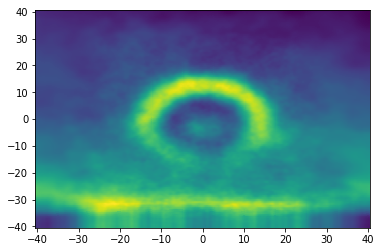

In [57]:
plt.pcolormesh(yy,zz,np.sqrt(uvar_mean[0,:,:]))